## Week 2: Tackle Overfitting with Data Augmentation

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import random
import os

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
zip_path = tf.keras.utils.get_file(origin=dataset_url, extract=False)

In [3]:
data_path = os.path.dirname(zip_path)
source_path = os.path.join(data_path, 'PetImages')
source_path_cats = os.path.join(source_path, 'Cat')
source_path_dogs = os.path.join(source_path, 'Dog')

#### Data cleaning

In [4]:
file1_path = os.path.join(source_path_cats, 'Thumbs.db')
file2_path = os.path.join(source_path_dogs, 'Thumbs.db')

if os.path.exists(file1_path):
    os.remove(file1_path)

if os.path.exists(file2_path):
    os.remove(file2_path)

In [5]:
print(f'There are {len(os.listdir(source_path_dogs))} images of dogs')
print(f'There are {len(os.listdir(source_path_cats))} images of cats')

There are 12500 images of dogs
There are 12500 images of cats


In [6]:
root_dir = os.path.join(data_path, 'cats-v-dogs')

train_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
    os.makedirs(train_cats_dir)
    os.makedirs(train_dogs_dir)
    os.makedirs(validation_cats_dir)
    os.makedirs(validation_dogs_dir)

create_train_val_dirs(root_dir)

In [ ]:
def split_data(SOURCE_DIR, train_dir, VALIDATION_DIR, SPLIT_SIZE):

    source_files = []

    for image_name in os.listdir(SOURCE_DIR):
        image_path = os.path.join(SOURCE_DIR, image_name)
        try:
            img_bytes = tf.io.read_file(image_path)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
            print(f'Found bad path {image_path}')
            continue

        source_files.append(image_name)

    num_images = len(source_files)
    num_training = int(num_images * SPLIT_SIZE)
    list_files = random.sample(source_files, num_images)
    training_images = list_files[:num_training]
    validation_images = list_files[num_training:]

    for training_image in training_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, training_image), os.path.join(train_dir, training_image))

    for validation_image in validation_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, validation_image), os.path.join(VALIDATION_DIR, validation_image))

In [ ]:
# Empty directories in case you run this cell multiple times
if len(os.listdir(train_cats_dir)) > 0:
    for file in os.scandir(train_cats_dir):
        os.remove(file.path)
if len(os.listdir(train_dogs_dir)) > 0:
    for file in os.scandir(train_dogs_dir):
        os.remove(file.path)
if len(os.listdir(validation_cats_dir)) > 0:
    for file in os.scandir(validation_cats_dir):
        os.remove(file.path)
if len(os.listdir(validation_dogs_dir)) > 0:
    for file in os.scandir(validation_dogs_dir):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# NOTE: Messages about zero length images should be printed out
split_data(source_path_cats, train_cats_dir, validation_cats_dir, split_size)
split_data(source_path_dogs, train_dogs_dir, validation_dogs_dir, split_size)

In [ ]:
# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(source_path_cats))} images")
print(f"Original dog's directory has {len(os.listdir(source_path_dogs))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(train_cats_dir))} images of cats for training")
print(f"There are {len(os.listdir(train_dogs_dir))} images of dogs for training")
print(f"There are {len(os.listdir(validation_cats_dir))} images of cats for validation")
print(f"There are {len(os.listdir(validation_dogs_dir))} images of dogs for validation")

In [ ]:
# def train_val_generators(train_dir, VALIDATION_DIR):

#     train_datagen = ImageDataGenerator(rescale=1./255,
#                                        rotation_range=40,
#                                        width_shift_range=0.2,
#                                        height_shift_range=0.2,
#                                        shear_range=0.2,
#                                        zoom_range=0.2,
#                                        horizontal_flip=True)

#     train_generator = train_datagen.flow_from_directory(directory=train_dir,
#                                                         batch_size=20,
#                                                         class_mode='binary',
#                                                         target_size=(150, 150))

#     validation_datagen = ImageDataGenerator(rescale=1./255)

#     validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
#                                                                   batch_size=20,
#                                                                   class_mode='binary',
#                                                                   target_size=(150, 150))
#     return train_generator, validation_generator

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1, input_shape=(150, 150, 3)),
    # layers.RandomTranslation(0, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=128,
    image_size=(150, 150))

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    batch_size=32,
    image_size=(150, 150))

Found 22491 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.


#### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.8 and logs['val_accuracy'] > 0.8:
            print('\nReached 80% accuracy and validation accuracy so cancelling training')
            self.model.stop_training = True

In [12]:
def create_model():

    model = tf.keras.Sequential([ 
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    return model

In [13]:
model = create_model()

callbacks = myCallback()

history = model.fit(train_dataset,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_dataset,
                    callbacks=[callbacks])

Epoch 1/15
176/176 [==============================] - 56s 283ms/step - loss: 0.7181 - accuracy: 0.6102 - val_loss: 0.5932 - val_accuracy: 0.7000
Epoch 2/15
176/176 [==============================] - 59s 334ms/step - loss: 0.5923 - accuracy: 0.6852 - val_loss: 0.6781 - val_accuracy: 0.6204
Epoch 3/15
176/176 [==============================] - 61s 345ms/step - loss: 0.5488 - accuracy: 0.7182 - val_loss: 0.6465 - val_accuracy: 0.6756
Epoch 4/15
176/176 [==============================] - 60s 337ms/step - loss: 0.5144 - accuracy: 0.7483 - val_loss: 0.5539 - val_accuracy: 0.7364
Epoch 5/15
176/176 [==============================] - 61s 344ms/step - loss: 0.4909 - accuracy: 0.7598 - val_loss: 0.4678 - val_accuracy: 0.7972
Epoch 6/15
176/176 [==============================] - 62s 349ms/step - loss: 0.4699 - accuracy: 0.7765 - val_loss: 0.4242 - val_accuracy: 0.8116
Epoch 7/15
176/176 [==============================] - 60s 335ms/step - loss: 0.4498 - accuracy: 0.7886 - val_loss: 0.4007 - val_ac

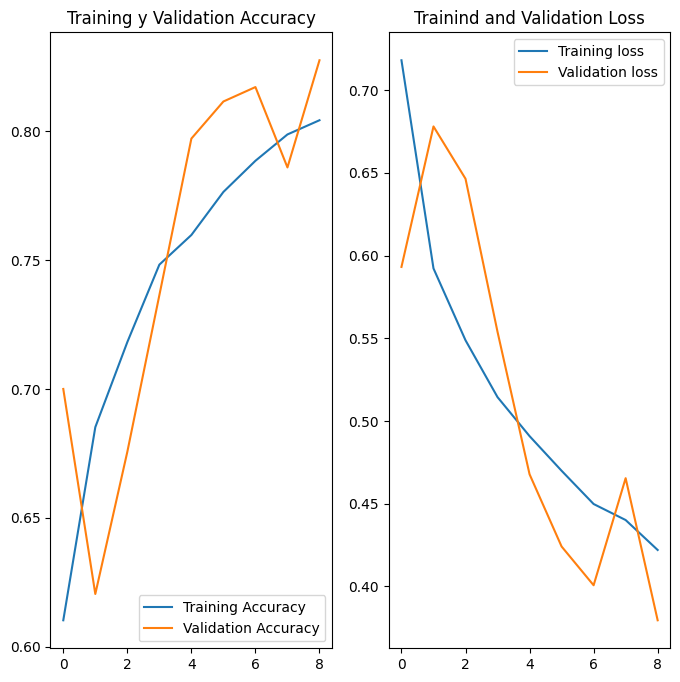

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()